# Frist try

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution

## Exploraiton Marchenko-Pastur distribution

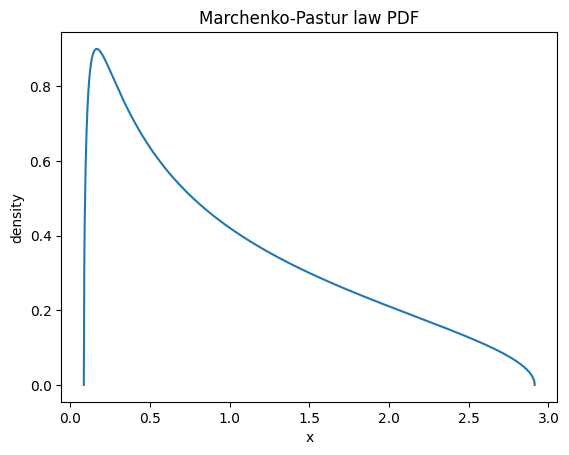

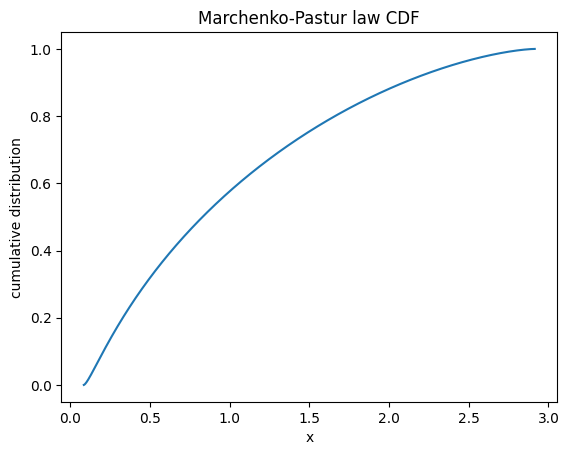

In [2]:
MP = MarchenkoPasturDistribution(ratio=0.5)

MP.plot_pdf()
MP.plot_cdf()

plt.show()

In [3]:
sigma = 1
dim_latent = 50
dim_ambiant = 100

n = 1000
ev = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_ambiant)) * np.random.randn(dim_ambiant, dim_latent)
    ev = np.concatenate((ev, np.linalg.eigvals(F.T @ F)))

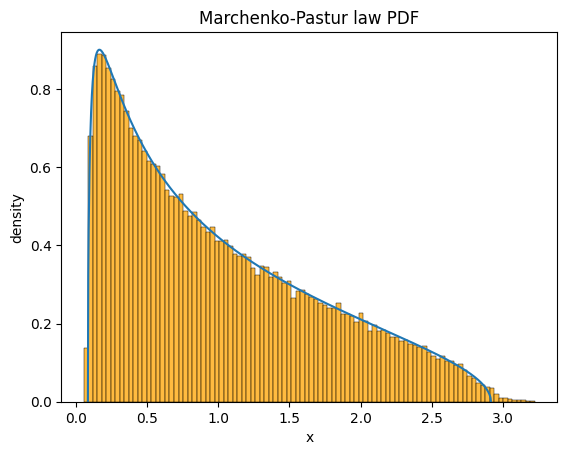

In [4]:
sns.histplot(ev, stat="density", bins=100, color='orange')
MP = MarchenkoPasturDistribution(ratio=dim_latent/dim_ambiant)
MP.plot_pdf()
plt.show()

In [5]:
MP.lambda_minus, MP.lambda_plus

(0.08578643762690492, 2.914213562373095)

To del

[WARNING - spectral_law]: Setting ratio >= 1.0 may cause numerical instability. Provided ratio = 2.0.


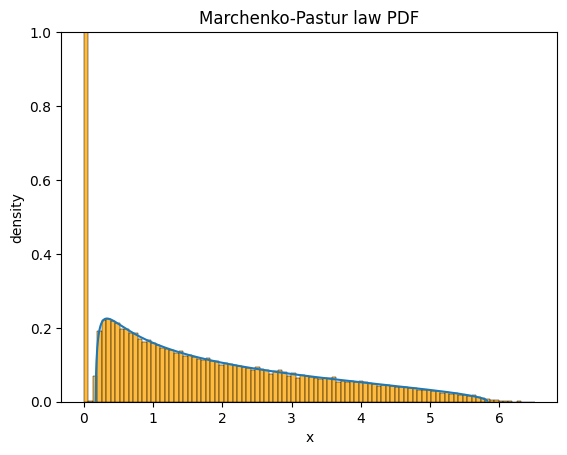

In [6]:
sigma = 1
dim_latent = 50
dim_ambiant = 100

n = 1000
ev_ = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
    ev_ = np.concatenate((ev_, np.linalg.eigvals(F @ F.T).real))

sns.histplot(ev_, stat="density", bins=100, color='orange')
MP_ = MarchenkoPasturDistribution(ratio=dim_ambiant/dim_latent)
plt.ylim((0, 1))
MP_.plot_pdf()

plt.show()

In [7]:
MP_._pdf(4)

0.052635549918474044

# Theory Jt

Recall that we have 

\begin{equation*}
J_t = \frac{1}{t} F \bigg [ I_m + \frac{1}{t} F^\top F \bigg ]^{-1} F^\top - I_d \in \mathbb{R}^{d\times d}
\end{equation*}

In [8]:
sigma = 1
dim_latent = 250
dim_ambiant = 500

t = 1

n = 100

ev = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
    J_t = (
        (1/t) * F @ np.linalg.inv(np.eye(dim_latent) + (1/t) * F.T @ F ) @ F.T
        - np.eye(dim_ambiant)
    )
    
    ev = np.concatenate((ev, np.linalg.eigvals(J_t).real))

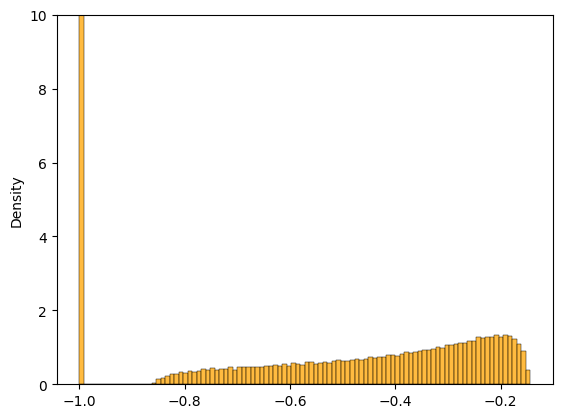

In [9]:
sns.histplot(ev, stat="density", bins=100, color='orange')
plt.ylim((0, 10))
plt.show()

In [10]:
MP = MarchenkoPasturDistribution(ratio=dim_ambiant/dim_latent)
gamma_plus = MP.lambda_minus
gap_theo = gamma_plus / (t + gamma_plus)
print("Theoretical gap", gap_theo)

empirical_gap = ev[ev > -0.999].min() + 1
print("Empirical gap", empirical_gap)

[WARNING - spectral_law]: Setting ratio >= 1.0 may cause numerical instability. Provided ratio = 2.0.


Theoretical gap 0.1464466094067263
Empirical gap 0.1371466024017528


In [11]:
print("Theoretical time", gamma_plus * ((1 - gap_theo)/gap_theo))
print("Ground truth time", t)
print("Empirical time", gamma_plus * ((1 - empirical_gap)/empirical_gap))

Theoretical time 1.0
Ground truth time 1
Empirical time 1.0794451758621044


In [12]:
alpha = dim_latent / dim_ambiant
gap_theo = 1 - t / (t + (1 - 1/np.sqrt(alpha))**2)
print("Theoretical gap", gap_theo)

empirical_gap = ev[ev > -0.999].min() + 1
print("Empirical gap", empirical_gap)

Theoretical gap 0.14644660940672605
Empirical gap 0.1371466024017528


# Theoretical distrib

The function that gives the eigenvalues $r$ of $J_{t}$ as function of $\gamma$ is

\begin{equation}
r_j=\frac{1}{t}\frac{\gamma_j}{1+\frac{1}{t}\gamma_j}-1=-\frac{t}{t+\gamma_j}
\end{equation}

Thus, knowing that the distribution of $\gamma$ is Marchenko-Pastur, we can obtain the distribution of $r$

\begin{equation}
    \rho_{t}(r)=-\frac{\alpha_m}{2\pi}\frac{1}{r(1+r)}\sqrt{\left(r_{+}-r\right)\left(r-r_{-}\right)}+\left(1-\alpha_m\right)\delta\left(r+1\right)\left(\alpha_m^{-1}-1\right)
\end{equation}

for $r\in[r_{-}(t),r_{+}(t)]$, with $r_{\pm}(t)=-\frac{t}{\left(1\pm\frac{1}{\sqrt{\alpha_m}}\right)^{2}+t}$.

This was the exact formula of the paper (Appendix A.1)

But it is false as you may see hereafter.

In [54]:
sigma = 1
dim_latent = 50
dim_ambiant = 100

t = 0.1

n = 1000

ev = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
    J_t = (
        (1/t) * F @ np.linalg.inv(np.eye(dim_latent) + (1/t) * F.T @ F ) @ F.T
        - np.eye(dim_ambiant)
    )
    ev = np.concatenate((ev, np.linalg.eigvals(J_t).real))

In [74]:
def rho(r, t, dim_ambiant, dim_latent):
    alpha_m = dim_latent / dim_ambiant

    lambda_plus = (1 + 1/np.sqrt(alpha_m))**2
    lambda_minus = (1 - 1/np.sqrt(alpha_m))**2
    
    r_plus = -t / (lambda_plus + t)
    r_minus = -t / (lambda_minus + t) 
    
    r_valid = (r > r_minus) & (r < r_plus)
    r = r[r_valid]
    r = np.concatenate((np.array([r_minus]), r, np.array([r_plus])))
    
    density = - (alpha_m / (2 * np.pi)) * (1 / (r * (1 + r))) * \
        np.sqrt((lambda_plus - (-t - (t / r))) * ((-t - (t / r)) - lambda_minus))
    
    return density, r

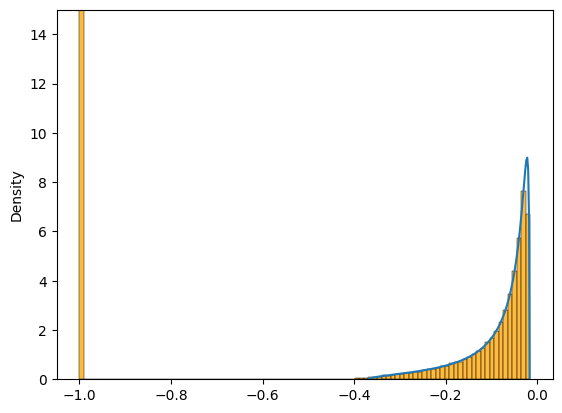

In [75]:
x = np.linspace(-2, 0, 1000)
y, x_valid = rho(x, t=t, dim_ambiant=dim_ambiant, dim_latent=dim_latent)
plt.plot(x_valid, y)
sns.histplot(ev, stat="density", bins=100, color='orange')
# ev[ev < -0.999] = 0
# sns.kdeplot(ev, bw_adjust=1, color='red')
# plt.hist(ev, density=True, bins=50, color='orange')
# plt.xlim((-1.25, 0.25))
plt.ylim((0, 15))
plt.show()

So it needs an official fix. Here is a quick one

[WARNING - spectral_law]: Setting ratio >= 1.0 may cause numerical instability. Provided ratio = 2.0.
/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_71171/3328065324.py:35: RuntimeWarning: divide by zero encountered in divide
  y = (t / (x ** 2)) * MP._pdf(-t - (t / x))


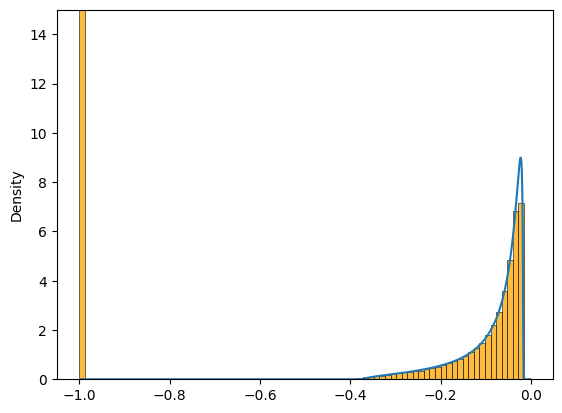

In [78]:
sigma = 1
dim_latent = 50
dim_ambiant = 100

t = 0.1

n = 1000

ev = np.array([])
for _ in range(n):
    F = (sigma/np.sqrt(dim_latent)) * np.random.randn(dim_ambiant, dim_latent)
    J_t = (
        (1/t) * F @ np.linalg.inv(np.eye(dim_latent) + (1/t) * F.T @ F ) @ F.T
        - np.eye(dim_ambiant)
    )
    ev = np.concatenate((ev, np.linalg.eigvals(J_t).real))


def rho(r, t, dim_ambiant, dim_latent):
    alpha_m = dim_latent / dim_ambiant
    
    r_plus = -t / ( (1 + 1/np.sqrt(alpha_m))**2 + t )
    r_minus = -t / ( (1 - 1/np.sqrt(alpha_m))**2 + t ) 
    
    r_valid = (r > r_minus) & (r < r_plus)
    r = r[r_valid]
    r = np.concatenate((np.array([r_minus]), r, np.array([r_plus])))
    
    density = - (alpha_m / (2 * np.pi)) * (1 / (r * (1 + r))) * np.sqrt(((1 + 1/np.sqrt(alpha_m))**2 - (-t - (t / r))) * ((-t - (t / r)) - (1 - 1/np.sqrt(alpha_m))**2))
    
    return density, r

x = np.linspace(-1, 0, 1000)
MP = MarchenkoPasturDistribution(ratio=dim_ambiant/dim_latent)
y = (t / (x ** 2)) * MP._pdf(-t - (t / x))
#y_2, x_2= rho(x, t=t, dim_ambiant=dim_ambiant, dim_latent=dim_latent)


plt.plot(x, y)
sns.histplot(ev, stat="density", bins=80, color='orange')
# sns.histplot(ev[ev > -0.999], stat="density", bins=80, color='orange')
# plt.hist(ev, density=True, bins=50, color='orange')
# plt.xlim((-1.25, 0.25))
plt.ylim((0, 15))
plt.show()